In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time

import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, SMOTENC

import sklearn
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn import svm
from sklearn.svm import SVC, OneClassSVM
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, auc, \
    classification_report, multilabel_confusion_matrix, precision_recall_curve, roc_curve, average_precision_score, \
    make_scorer
from lightgbm import LGBMClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier

from src.config import Config
from src.analysis import Analysis
from src.train import Train

analysis = Analysis()
train = Train()

pd.set_option('display.max_rows', 500)

%matplotlib inline
%matplotlib agg

In [13]:
combined_df1 = analysis.read_file("./data/combined_dataset1.csv")
combined_df2 = analysis.read_file("./data/combined_dataset2.csv")
combined_df3 = analysis.read_file("./data/combined_dataset3.csv")
combined_df4 = analysis.read_file("./data/combined_dataset4.csv")

Reading file: ./data/combined_dataset1.csv ...
Data import complete for file: ./data/combined_dataset1.csv ...
Reading file: ./data/combined_dataset2.csv ...
Data import complete for file: ./data/combined_dataset2.csv ...
Reading file: ./data/combined_dataset3.csv ...
Data import complete for file: ./data/combined_dataset3.csv ...
Reading file: ./data/combined_dataset4.csv ...
Data import complete for file: ./data/combined_dataset4.csv ...


# Selection of Evaluation Metrics

Summary: 
- Choice of metrics: F1-score for baseline models, Recall for best model
- Choice of averaging technique for multi-class evaluation: 'Weighted' average

Justification for Choice of Metrics:

In ML projects best practices, we start off by selecting the evaluation metrics and selection criteria to decide on the best model. Here are some considerations: 
- This is a classification problem, the evaluation metrics will be accuracy, precision, recall, f1-score, AUC for ROC or PR plots. 
- Due to the heavily imbalanced dataset, accuracy is not a good evaluation metrics as most likely we will get a very high accuracy (models tend to predict well for majority class). 
- Between precision and recall, if the minority class are defects and the company requires zero-tolerance on compliance, then recall is preferred over precision. Recall measures how well the minority class is correctly classified i.e. quality, precision measures the percentage of minority class belongs to the group that is correctly classified i.e. quantity. In most cases, we will look at both metrics to evaluate the effectiveness of the model i.e. f1-score which is the harmonic mean of both precision and recall. 
- The strategy is first to build a baseline model based on loose/less strict evaluation metrics i.e. f1-score/auc curve then when trying to get the best model, we focus on optimizing the model performance for recall. 
- Point to note: AUC curve in this case, might or might not be helpful due to the highly imbalances target class i.e. similar to that of accuracy. 

Justification for Choice of Averaging Technique:

Due to the multi-class condition, the evaluation metrics will return different result for different class, so here are some considerations: 
- The grand average of the evaluation metrics can be computed by either 'macro', 'micro' or 'weighted'. 'Macro' average is not preferred since it gives equal weights to the scores. 
- Between 'micro' and 'weighted', the selection is 'weighted' because it looks at the proportion of each classes over the entire population. The way 'micro' calculates is such that micro-precision = micro-recall = micro-accuracy, which we knew from the previous section, it will not be suited for a highly imbalanced dataset. 

# Model Strategy

After selecting the evaluation metrics, we can get started to build our baseline model. Here are the modelling strategy: 
- Step 1: Hyperparameter tuning can only help to the extend of how good the data is. Considering the time constraint, the focus would be to explore which model performs the best without any hyperparameter tuning and without any data cleaning first (except missing data cleaning)
- Step 2: Based on selected model, improve data by performing data cleaning (missing and outlier), feature transformation, feature engineering and feature selection
- Step 3: Perform hyperparameter tuning 
- Step 4: Preventative measures for overfitting/underfitting
- Step 5: Selection of model and recommend way forward

Models to try: 
- Logistic Regression Model
- Tree-based Model 
    - Bagging trees: Random Forest
    - Boosting trees: LightGBM Model
- Support Vector Model
- Dual-stage modelling i.e. Anomaly-based detection model: One-class SVM -> K-means clustering 
- Artificial Neural Nets

# Baseline Model Selection

<AxesSubplot:ylabel='None'>

Evaluation metrics for Logistic Regression:


,precision,recall,f1-score,support
0,0.976981,0.999664,0.988192,2972.000000
1,0.666667,0.066667,0.121212,30.000000
2,0.000000,0.000000,0.000000,18.000000
3,0.000000,0.000000,0.000000,16.000000
4,0.000000,0.000000,0.000000,8.000000
accuracy,0.976675,0.976675,0.976675,0.976675
macro avg,0.328730,0.213266,0.221881,3044.000000
weighted avg,0.960443,0.976675,0.966013,3044.000000


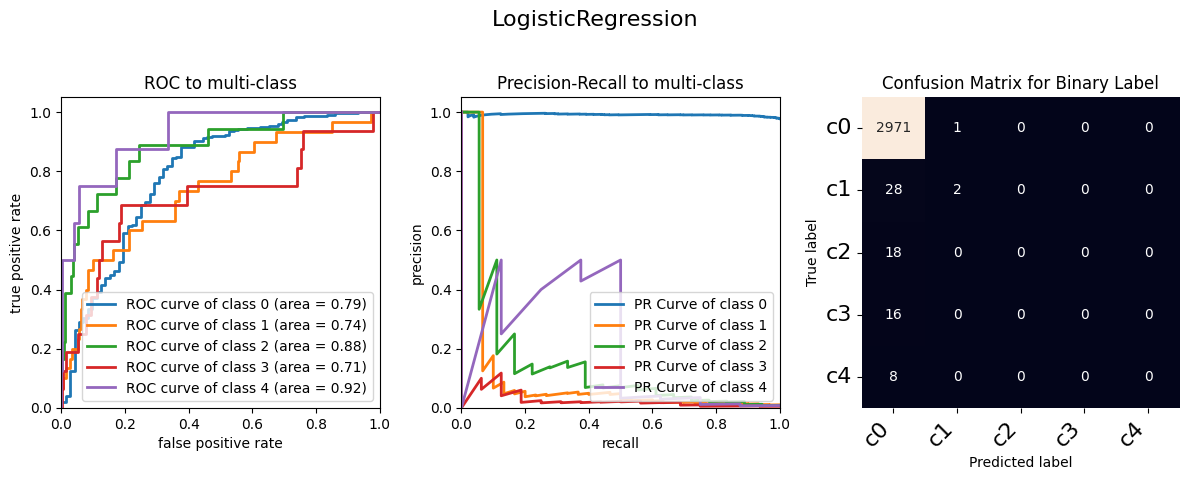

In [14]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df1, 'fs1.sav', retrain=False)
# lr_dataset1 = LogisticRegression(random_state=123).fit(X_train, y_train)
filename = './models/models_new/logreg_baseline_dataset1.sav'
# pickle.dump(lr_dataset1, open(filename, 'wb'))
lr_dataset1 = pickle.load(open(filename, 'rb'))
y_pred = lr_dataset1.predict(X_test)
print("Evaluation metrics for Logistic Regression:")
report_logreg = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_logreg)
train.plot_graphs(X_test, y_test, y_pred, lr_dataset1)

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for Weighted Logistic Regression:


,precision,recall,f1-score,support
0,0.989868,0.657470,0.790133,2972.000000
1,0.023555,0.366667,0.044266,30.000000
2,0.084270,0.833333,0.153061,18.000000
3,0.009231,0.187500,0.017595,16.000000
4,0.060000,0.750000,0.111111,8.000000
accuracy,0.653417,0.653417,0.653417,0.653417
macro avg,0.233385,0.558994,0.223233,3044.000000
weighted avg,0.967392,0.653417,0.773170,3044.000000


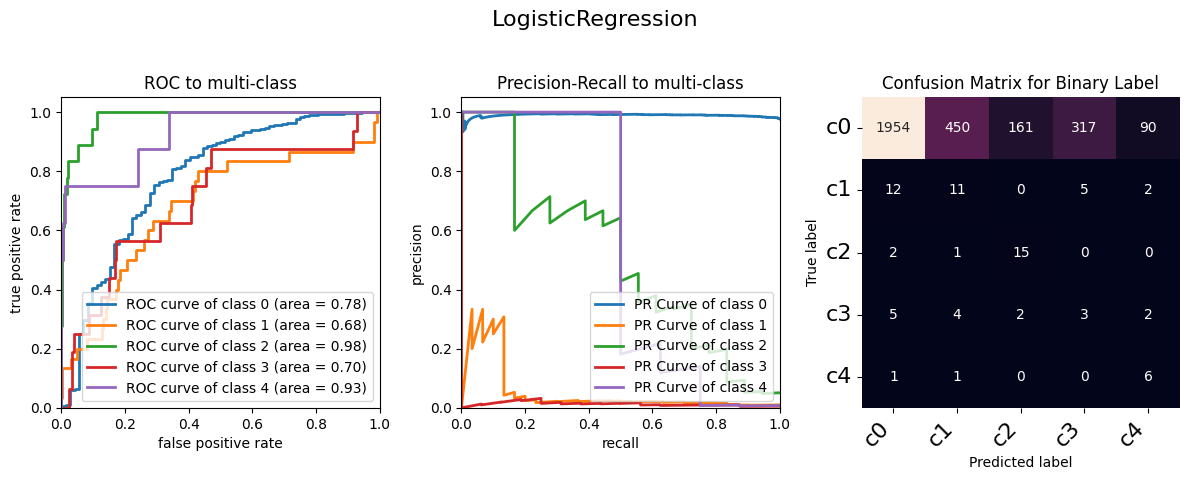

In [15]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df1, 'fs1.sav', retrain=False)
# lr_dataset2 = LogisticRegression(class_weight='balanced', random_state=123).fit(X_train, y_train)
filename = './models/models_new/weightedlogreg_baseline_dataset1.sav'
# pickle.dump(lr_dataset2, open(filename, 'wb'))
lr_dataset2 = pickle.load(open(filename, 'rb'))
y_pred = lr_dataset2.predict(X_test)
print("Evaluation metrics for Weighted Logistic Regression:")
report_weightlogreg = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_weightlogreg)
train.plot_graphs(X_test, y_test, y_pred, lr_dataset2)

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for Random Forest Classifier:


,precision,recall,f1-score,support
0,0.984106,1.000000,0.991989,2972.000000
1,0.000000,0.000000,0.000000,30.000000
2,1.000000,1.000000,1.000000,18.000000
3,0.333333,0.062500,0.105263,16.000000
4,1.000000,0.375000,0.545455,8.000000
accuracy,0.983574,0.983574,0.983574,0.983574
macro avg,0.663488,0.487500,0.528541,3044.000000
weighted avg,0.971122,0.983574,0.976426,3044.000000


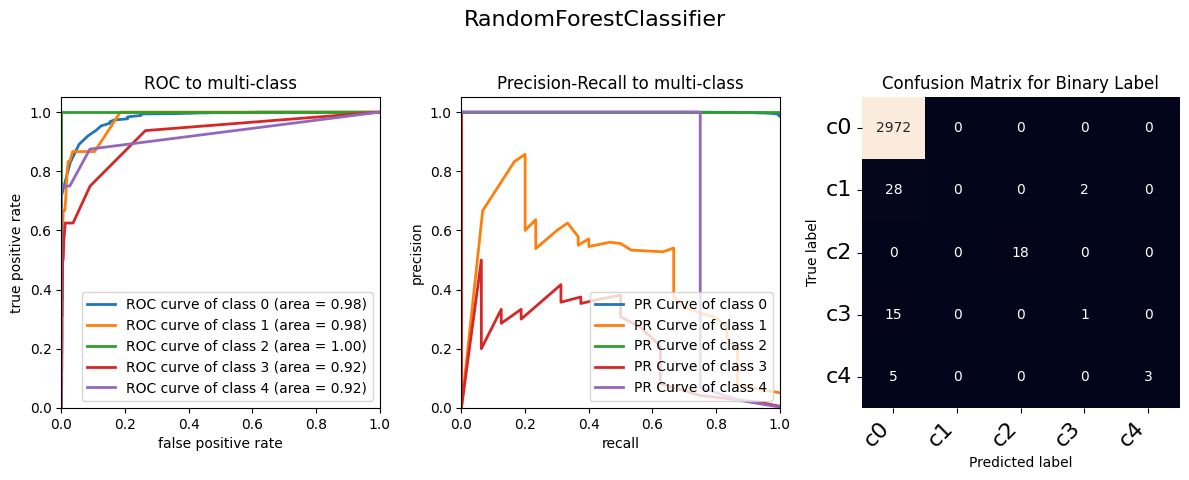

In [16]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df1, 'fs1.sav', retrain=False)
# rf_model = RandomForestClassifier(random_state=123).fit(X_train, y_train)
filename = './models/models_new/rf_baseline_dataset1.sav'
# pickle.dump(rf_model, open(filename, 'wb'))
rf_model = pickle.load(open(filename, 'rb'))
y_pred = rf_model.predict(X_test)
print("Evaluation metrics for Random Forest Classifier:")
report_rf = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_rf)
train.plot_graphs(X_test, y_test, y_pred, rf_model)

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for Light Gradient Boosting Classifier:


,precision,recall,f1-score,support
0,0.996647,1.000000,0.998320,2972.000000
1,0.958333,0.766667,0.851852,30.000000
2,1.000000,1.000000,1.000000,18.000000
3,1.000000,0.875000,0.933333,16.000000
4,1.000000,0.750000,0.857143,8.000000
accuracy,0.996386,0.996386,0.996386,0.996386
macro avg,0.990996,0.878333,0.928130,3044.000000
weighted avg,0.996315,0.996386,0.996174,3044.000000


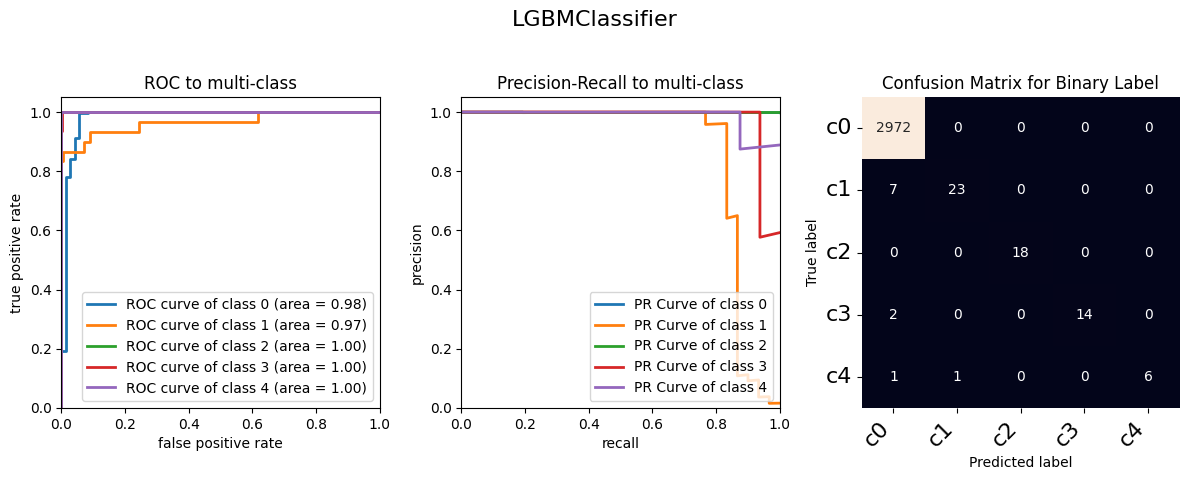

In [17]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df1, 'fs1.sav', retrain=False)
# lgbm_model = LGBMClassifier(random_state=123).fit(X_train, y_train)
filename = './models/models_new/lgbm_baseline_dataset0.sav'
# pickle.dump(lgbm_model, open(filename, 'wb'))
lgbm_model = pickle.load(open(filename, 'rb'))
y_pred = lgbm_model.predict(X_test)
print("Evaluation metrics for Light Gradient Boosting Classifier:")
report_lgbm = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_lgbm)
train.plot_graphs(X_test, y_test, y_pred, lgbm_model)

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for Linear Support Vector Classifier:


,precision,recall,f1-score,support
0,0.983411,0.997308,0.990311,2972.000000
1,0.750000,0.100000,0.176471,30.000000
2,0.722222,0.722222,0.722222,18.000000
3,1.000000,0.062500,0.117647,16.000000
4,0.571429,0.500000,0.533333,8.000000
accuracy,0.980618,0.980618,0.980618,0.980618
macro avg,0.805412,0.476406,0.507997,3044.000000
weighted avg,0.978570,0.980618,0.974917,3044.000000


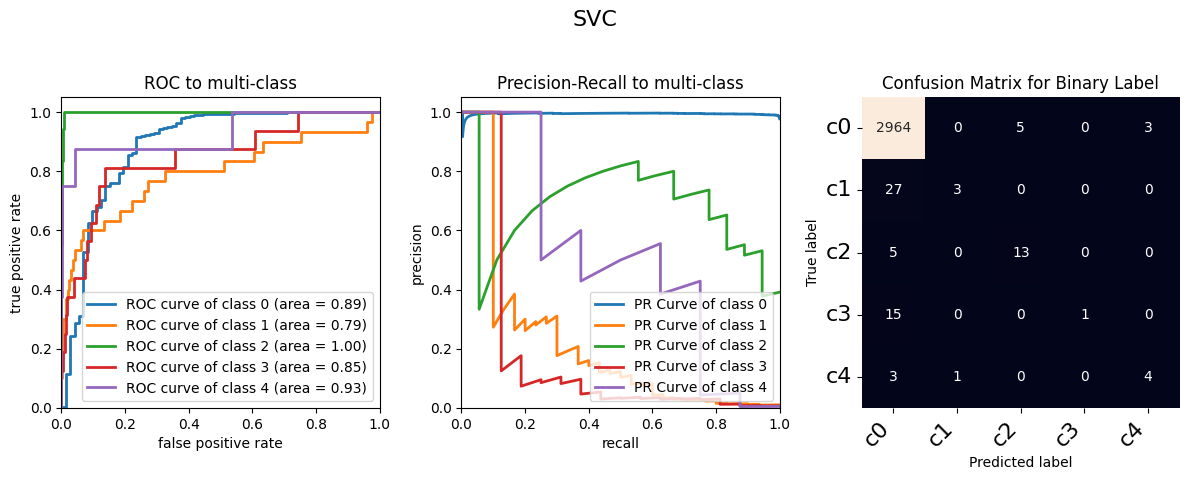

In [18]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df1, 'fs1.sav', retrain=False)
svm_model = SVC(kernel='linear',probability=True, random_state=123).fit(X_train, y_train)
filename = './models/models_new/svc_baseline_dataset1.sav'
pickle.dump(svm_model, open(filename, 'wb'))
svm_model = pickle.load(open(filename, 'rb'))
y_pred = svm_model.predict(X_test)
print("Evaluation metrics for Linear Support Vector Classifier:")
report_svc = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_svc)
train.plot_graphs(X_test, y_test, y_pred, svm_model)

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for Radial-Basis Support Vector Classifier:


,precision,recall,f1-score,support
0,0.984748,0.999327,0.991984,2972.000000
1,1.000000,0.066667,0.125000,30.000000
2,0.947368,1.000000,0.972973,18.000000
3,0.000000,0.000000,0.000000,16.000000
4,0.857143,0.750000,0.800000,8.000000
accuracy,0.984231,0.984231,0.984231,0.984231
macro avg,0.757852,0.563199,0.577991,3044.000000
weighted avg,0.979166,0.984231,0.977608,3044.000000


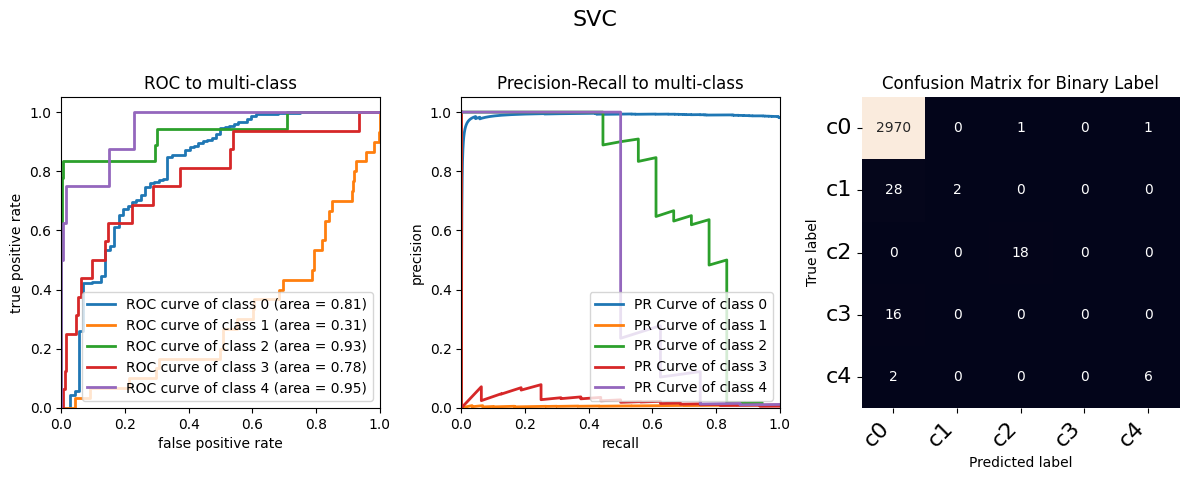

In [19]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df1, 'fs1.sav', retrain=False)

svm_kernel = SVC(kernel='rbf',probability=True, random_state=123).fit(X_train, y_train)
filename = './models/models_new/svk_baseline_dataset1.sav'
pickle.dump(svm_kernel, open(filename, 'wb'))
svm_kernel = pickle.load(open(filename, 'rb'))
y_pred = svm_model.predict(X_test)
print("Evaluation metrics for Radial-Basis Support Vector Classifier:")
report_svk = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_svk)
train.plot_graphs(X_test, y_test, y_pred, svm_kernel)

## Interpretation


Logistic Regression Observations: 

1.	The evaluation metrics using weighted average is misleading. Further checks on other model to decide to go forward with macro average or weighted average. However, will evaluate based on macro averages for now. 
2.	Logistic regression performed poorly in f1-score (22%) and recall (21%). There were no correctly identified labels for class 2,3 and 4. This is surprising based on the previous extensive study; as we would expect class 2 to be classified well. 
3.	Logistic regression violated the non-negotiables of this use case i.e. did not able to classify all classes. We would directly omit this from the list. I would give weighted logistic regression a try. 

Weighted Logistic Regression Observations: 
1.	F1-score is lower (18%) than logistic regression (22%), but improvement is seen in recall (44%). 
2.	All classes were classified but very poor precision score for all minority classes. 

Random Forest Classifier Observations: 
1.	F1-score went up to 53%, recall went up to 51% and precision achieved highest score (74%) for now. 
2.	Class 2 exhibits 100% recall (as we expected), however it did not manage to classify class 1. Although this makes sense since we saw the between group differences for class 1 and the rest is not significant, it still violated our non-negotiable.  

LightGBM Classifier Observations: 
1.	F1-score went up to 55%, recall went down by 2% (very trivial differences) from the Random Forest model. However, precision achieved highest score (95%!). Note, this is before data transformation and hyperparameter tuning! 
2.	All classes were classified, great! Class 1, 3 and 4 were poorly classified, however, can be improved with feature transformation, engineering and selection. 
3.	Our best model thus far. 

Support Vector Classifier (Linear and RBF) Observations: 
1.	Both linear and rbf kernel produce same results. 
2.	F1-score went up by 1%, recall went up by 3% from the LightGBM model. However, precision drop down to 78%. Although precision is not our target evaluation metrics, we wouldn’t want it to be too low either. 
3.	Class 1 and 3 are poorly classified. 


# Model Impovement

## Different Subsets

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for LGBM with dataset 2:


,precision,recall,f1-score,support
0,0.996657,1.000000,0.998326,2385.00000
1,0.961538,0.833333,0.892857,30.00000
2,1.000000,1.000000,1.000000,18.00000
3,1.000000,0.750000,0.857143,16.00000
4,0.875000,0.875000,0.875000,8.00000
accuracy,0.995930,0.995930,0.995930,0.99593
macro avg,0.966639,0.891667,0.924665,2457.00000
weighted avg,0.995878,0.995930,0.995729,2457.00000


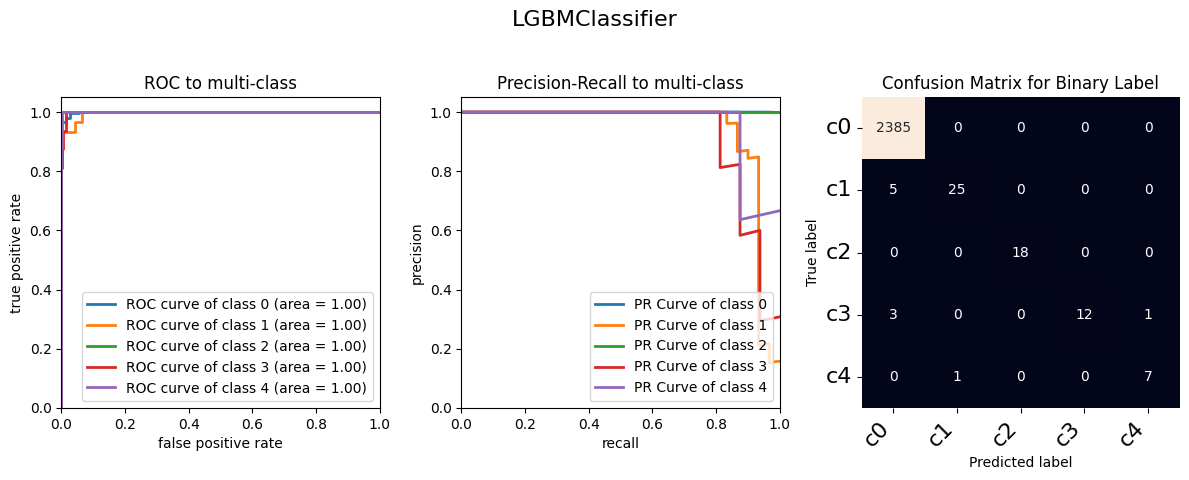

In [20]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df2, 'fs2.sav', retrain=False)
# lgbm_model = LGBMClassifier(random_state=123).fit(X_train, y_train)
filename = './models/models_new/lgbm_dataset2.sav'
# pickle.dump(lgbm_model, open(filename, 'wb'))
lgbm_model = pickle.load(open(filename, 'rb'))
y_pred = lgbm_model.predict(X_test)
print("Evaluation metrics for LGBM with dataset 2:")
report_subset2 = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_subset2)
train.plot_graphs(X_test, y_test, y_pred, lgbm_model)

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for LGBM with dataset 3:


,precision,recall,f1-score,support
0,0.995409,1.000000,0.997699,2385.000000
1,1.000000,0.733333,0.846154,30.000000
2,1.000000,1.000000,1.000000,18.000000
3,1.000000,0.812500,0.896552,16.000000
4,1.000000,1.000000,1.000000,8.000000
accuracy,0.995523,0.995523,0.995523,0.995523
macro avg,0.999082,0.909167,0.948081,2457.000000
weighted avg,0.995544,0.995523,0.995215,2457.000000


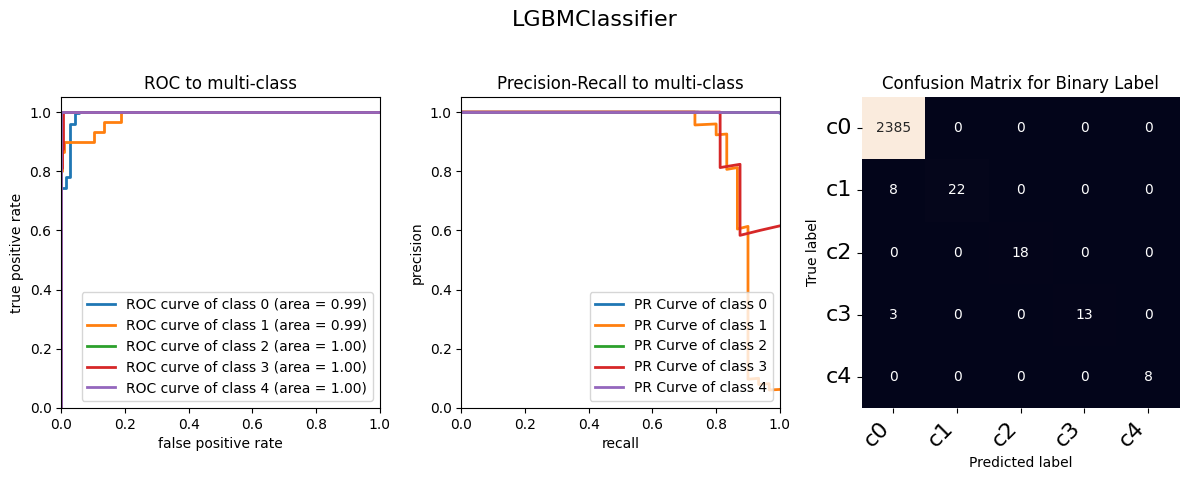

In [21]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df3, 'fs3.sav', retrain=False)
# lgbm_model = LGBMClassifier(random_state=123).fit(X_train, y_train)
filename = './models/models_new/lgbm_dataset3.sav'
# pickle.dump(lgbm_model, open(filename, 'wb'))
lgbm_model = pickle.load(open(filename, 'rb'))
y_pred = lgbm_model.predict(X_test)
print("Evaluation metrics for LGBM with dataset 3:")
report_subset3 = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_subset3)
train.plot_graphs(X_test, y_test, y_pred, lgbm_model)

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for LGBM with dataset 4:


,precision,recall,f1-score,support
0,0.996657,1.000000,0.998326,2385.000000
1,1.000000,0.866667,0.928571,30.000000
2,1.000000,1.000000,1.000000,18.000000
3,1.000000,0.812500,0.896552,16.000000
4,1.000000,0.875000,0.933333,8.000000
accuracy,0.996744,0.996744,0.996744,0.996744
macro avg,0.999331,0.910833,0.951356,2457.000000
weighted avg,0.996755,0.996744,0.996612,2457.000000


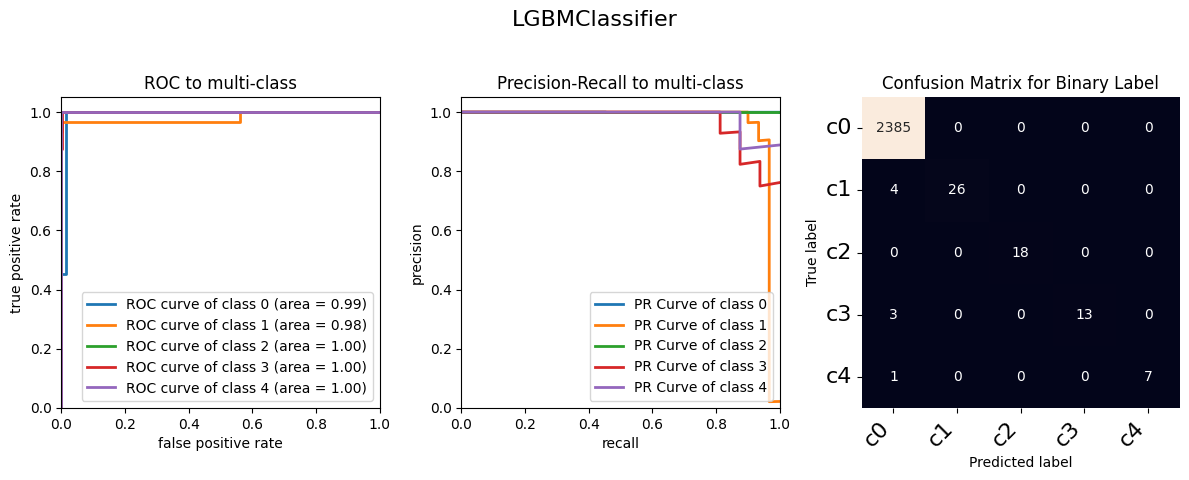

In [22]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df4, 'fs4.sav', retrain=False)
# lgbm_model = LGBMClassifier(random_state=123).fit(X_train, y_train)
filename = './models/models_new/lgbm_dataset4.sav'
# pickle.dump(lgbm_model, open(filename, 'wb'))
lgbm_model = pickle.load(open(filename, 'rb'))
y_pred = lgbm_model.predict(X_test)
print("Evaluation metrics for LGBM with dataset 4:")
report_subset4 = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_subset4)
train.plot_graphs(X_test, y_test, y_pred, lgbm_model)

## Oversampling vs. No Oversampling

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for LGBM with dataset 4 without oversampling:


,precision,recall,f1-score,support
0,0.997491,1.000000,0.998744,2385.000000
1,1.000000,0.866667,0.928571,30.000000
2,1.000000,1.000000,1.000000,18.000000
3,0.933333,0.875000,0.903226,16.000000
4,1.000000,0.875000,0.933333,8.000000
accuracy,0.997151,0.997151,0.997151,0.997151
macro avg,0.986165,0.923333,0.952775,2457.000000
weighted avg,0.997130,0.997151,0.997061,2457.000000


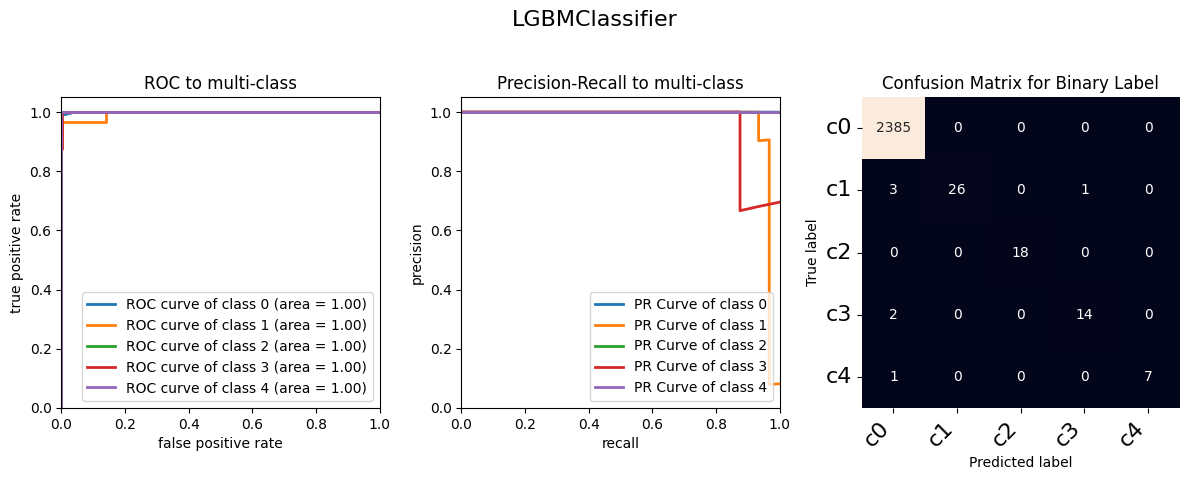

In [23]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df4, 'fs4.sav', retrain=False)
filename = './models/models_new/lgbm_dataset4.sav'
lgbm_model = pickle.load(open(filename, 'rb'))
y_pred = lgbm_model.predict(X_test)
print("Evaluation metrics for LGBM with dataset 4 without oversampling:")
report_subset4 = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_subset4)
train.plot_graphs(X_test, y_test, y_pred, lgbm_model)

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for LGBM with dataset 4 with oversampling:


,precision,recall,f1-score,support
0,0.994994,1.000000,0.997491,2385.000000
1,0.956522,0.733333,0.830189,30.000000
2,1.000000,1.000000,1.000000,18.000000
3,1.000000,0.750000,0.857143,16.000000
4,0.857143,0.750000,0.800000,8.000000
accuracy,0.994302,0.994302,0.994302,0.994302
macro avg,0.961732,0.846667,0.896964,2457.000000
weighted avg,0.994144,0.994302,0.993909,2457.000000


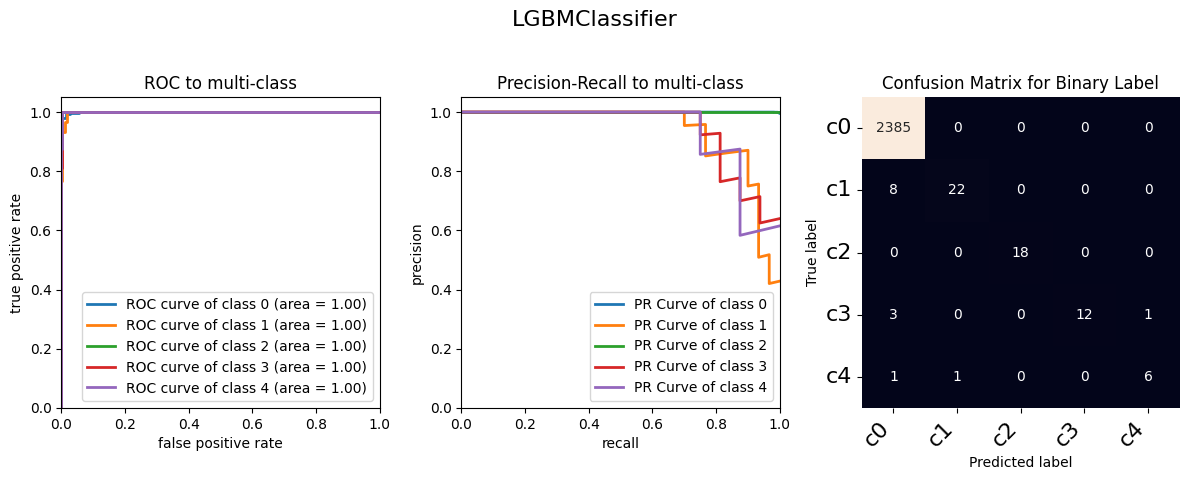

In [24]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df4, 'fs4.sav', retrain=False)
# lgbm_model = LGBMClassifier(random_state=123).fit(X_otrain, y_otrain)
filename = './models/models_new/lgbm_dataset4_oversampling.sav'
# pickle.dump(lgbm_model, open(filename, 'wb'))
lgbm_model = pickle.load(open(filename, 'rb'))
y_pred = lgbm_model.predict(X_test)
print("Evaluation metrics for LGBM with dataset 4 with oversampling:")
report_oversampling = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_oversampling)
train.plot_graphs(X_test, y_test, y_pred, lgbm_model)

## Hyperparameter tuning and Dealing with Overfitting and Underfitting 

In next notebook, using bayesian optimizer to perform hyperparameter tuning along with kfold cross validation. 

Best Parameters: {'learning_rate': 0.6960720013050441, 'max_depth': 6.0, 'n_estimators': 1181.0, 'num_leaves': 69.0, 'subsample': 0.3646666061385309}

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for LGBM with dataset 4 with oversampling:


,precision,recall,f1-score,support
0,0.995825,1.000000,0.997908,2385.000000
1,0.960000,0.800000,0.872727,30.000000
2,1.000000,1.000000,1.000000,18.000000
3,1.000000,0.812500,0.896552,16.000000
4,1.000000,0.750000,0.857143,8.000000
accuracy,0.995523,0.995523,0.995523,0.995523
macro avg,0.991165,0.872500,0.924866,2457.000000
weighted avg,0.995459,0.995523,0.995276,2457.000000


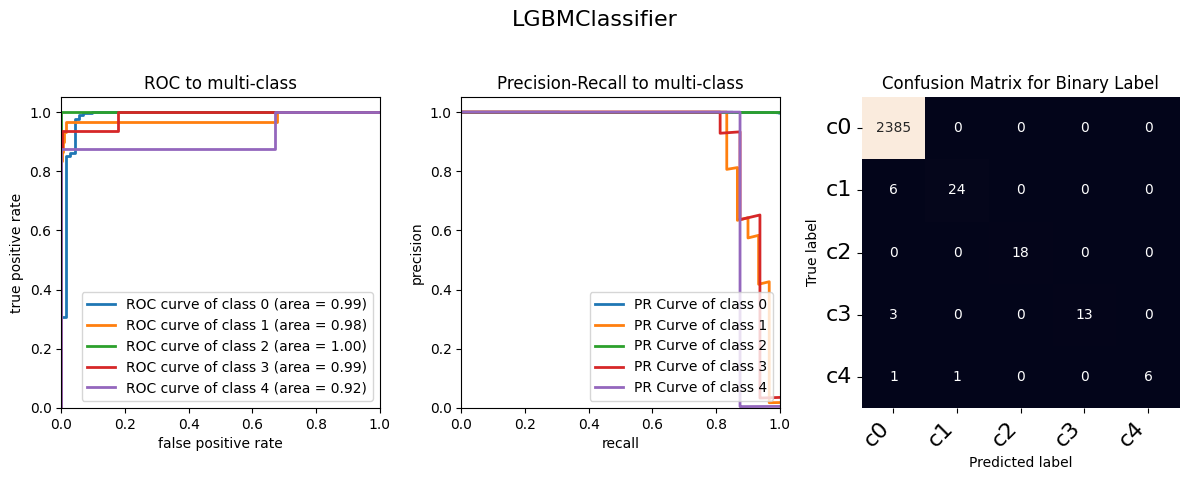

In [25]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df4, 'fs4.sav', retrain=False)
# lgbm_model = LGBMClassifier(learning_rate=0.6960720013050441, max_depth= 6, n_estimators= 1181, num_leaves= 69, subsample= 0.3646666061385309, random_state=123).fit(X_otrain, y_otrain)
filename = './models/models_new/lgbm_dataset4_tuned.sav'
# pickle.dump(lgbm_model, open(filename, 'wb'))
lgbm_model = pickle.load(open(filename, 'rb'))
y_pred = lgbm_model.predict(X_test)
print("Evaluation metrics for LGBM with dataset 4 with oversampling:")
report_oversampling_tuned = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_oversampling_tuned)
train.plot_graphs(X_test, y_test, y_pred, lgbm_model)

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for LGBM with dataset 4 with oversampling:


,precision,recall,f1-score,support
0,0.986760,1.000000,0.993336,2385.000000
1,0.764706,0.433333,0.553191,30.000000
2,0.944444,0.944444,0.944444,18.000000
3,0.333333,0.062500,0.105263,16.000000
4,1.000000,0.250000,0.400000,8.000000
accuracy,0.984127,0.984127,0.984127,0.984127
macro avg,0.805849,0.538056,0.599247,2457.000000
weighted avg,0.979527,0.984127,0.979889,2457.000000


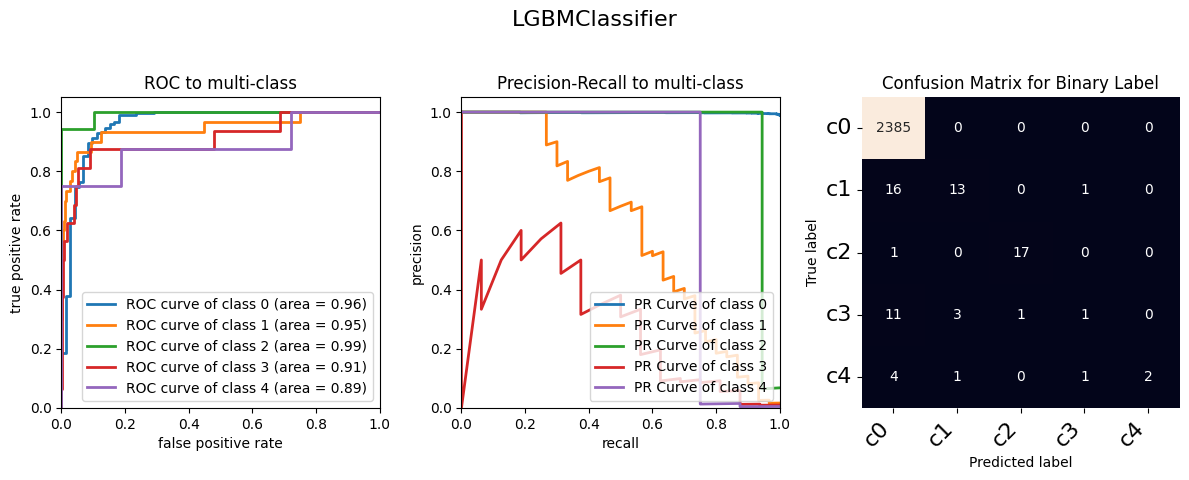

In [98]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df4, 'fs4.sav', retrain=False)
# lgbm_model = LGBMClassifier(reg_alpha=0.001, learning_rate=0.6960720013050441, max_depth= 6, n_estimators= 1181, num_leaves= 69, subsample= 0.3646666061385309, random_state=123).fit(X_otrain, y_otrain)
filename = './models/models_new/lgbm_dataset4_tuned_l1regularized.sav'
# pickle.dump(lgbm_model, open(filename, 'wb'))
lgbm_model = pickle.load(open(filename, 'rb'))
y_pred = lgbm_model.predict(X_test)
print("Evaluation metrics for LGBM with dataset 4 with oversampling:")
report_l1regularized = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_l1regularized)
train.plot_graphs(X_test, y_test, y_pred, lgbm_model)

<AxesSubplot:title={'center':'Confusion Matrix for Binary Label'}, xlabel='Predicted label', ylabel='None'>

Evaluation metrics for LGBM with dataset 4 with oversampling:


,precision,recall,f1-score,support
0,0.997074,1.000000,0.998535,2385.000000
1,1.000000,0.866667,0.928571,30.000000
2,1.000000,1.000000,1.000000,18.000000
3,0.928571,0.812500,0.866667,16.000000
4,1.000000,0.875000,0.933333,8.000000
accuracy,0.996744,0.996744,0.996744,0.996744
macro avg,0.985129,0.910833,0.945421,2457.000000
weighted avg,0.996694,0.996744,0.996620,2457.000000


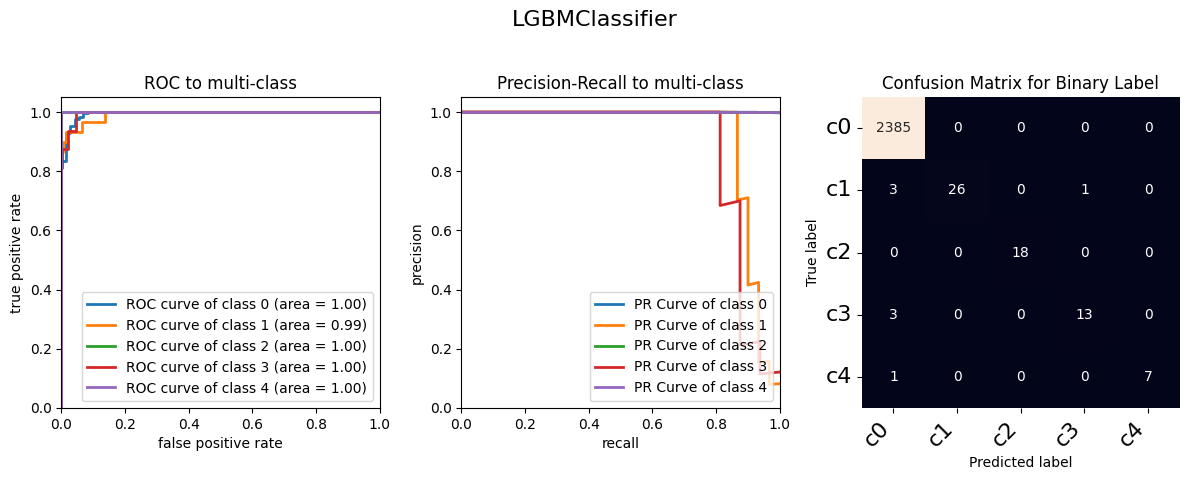

In [106]:
X_train, X_test, y_train, y_test, X_otrain, y_otrain = train.data_prep(combined_df4, 'fs4.sav', retrain=False)
# lgbm_model = LGBMClassifier(reg_lambda=1, learning_rate=0.6960720013050441, max_depth= 6, n_estimators= 1181, num_leaves= 69, subsample= 0.3646666061385309, random_state=123).fit(X_otrain, y_otrain)
filename = './models/models_new/lgbm_dataset4_tuned_l2regularized.sav'
# pickle.dump(lgbm_model, open(filename, 'wb'))
lgbm_model = pickle.load(open(filename, 'rb'))
y_pred = lgbm_model.predict(X_test)
print("Evaluation metrics for LGBM with dataset 4 with oversampling:")
report_l2regularized = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(report_l2regularized)
train.plot_graphs(X_test, y_test, y_pred, lgbm_model)

# Results consolidation

In [100]:
reports = [report_logreg, report_weightlogreg, report_rf, report_lgbm, report_svc, report_svk]
model = ["Logistic Regression", "Weighted Logistic Regression",
         "Random Forest", "Light GBM", 
         "Linear SVC", "RBF SVC"]
method = "macro avg"
macro_results = []
for i, report in enumerate(reports):
    macro_avg = list(report.loc[report.index == method,:].values[0])
    macro_results.append(macro_avg)
macro_results = pd.DataFrame(macro_results, columns=reports[0].columns)
macro_df = pd.DataFrame({"Technique": "No Outlier Removal, Feature Engineering and Transformation",
                         "Phase"    : "Baseline Model Selection",
                         "Model Name": model, 
                         "Averaging Technique": method, 
                         "Oversampling": "No"})   
macro_df = pd.concat([macro_df, macro_results], axis=1)
display(macro_df)
# macro_df.to_csv("baseline_model_selection_macro.csv", index=False)

,Technique,Phase,Model Name,Averaging Technique,Oversampling,precision,recall,f1-score,support
0,"No Outlier Removal, Feature Engineering and Tr...",Baseline Model Selection,Logistic Regression,macro avg,No,0.328730,0.213266,0.221881,3044.0
1,"No Outlier Removal, Feature Engineering and Tr...",Baseline Model Selection,Weighted Logistic Regression,macro avg,No,0.233385,0.558994,0.223233,3044.0
2,"No Outlier Removal, Feature Engineering and Tr...",Baseline Model Selection,Random Forest,macro avg,No,0.663488,0.487500,0.528541,3044.0
3,"No Outlier Removal, Feature Engineering and Tr...",Baseline Model Selection,Light GBM,macro avg,No,0.990996,0.878333,0.928130,3044.0
4,"No Outlier Removal, Feature Engineering and Tr...",Baseline Model Selection,Linear SVC,macro avg,No,0.805412,0.476406,0.507997,3044.0
5,"No Outlier Removal, Feature Engineering and Tr...",Baseline Model Selection,RBF SVC,macro avg,No,0.757852,0.563199,0.577991,3044.0


In [101]:
reports = [report_logreg,report_weightlogreg, report_rf,report_lgbm,report_svc,report_svk]
model = ["Logistic Regression", "Weighted Logistic Regression",
         "Random Forest", "Light GBM", 
         "Linear SVC", "RBF SVC"]
method = "weighted avg"
weighted_results = []
for report in reports: 
    weighted_avg = list(report.loc[report.index == method,:].values[0])
    weighted_results.append(weighted_avg)
weighted_results = pd.DataFrame(weighted_results, columns=reports[0].columns)
weighted_df = pd.DataFrame({"Technique": "No Outlier Removal, Feature Engineering and Transformation",
                         "Phase"    : "Baseline Model Selection",
                         "Model Name": model, 
                         "Averaging Technique": method, 
                         "Oversampling": "No"})   
weighted_df = pd.concat([weighted_df, weighted_results], axis=1)
display(weighted_df)
# weighted_df.to_csv("baseline_model_selection_weighted.csv", index=False)

,Technique,Phase,Model Name,Averaging Technique,Oversampling,precision,recall,f1-score,support
0,"No Outlier Removal, Feature Engineering and Tr...",Baseline Model Selection,Logistic Regression,weighted avg,No,0.960443,0.976675,0.966013,3044.0
1,"No Outlier Removal, Feature Engineering and Tr...",Baseline Model Selection,Weighted Logistic Regression,weighted avg,No,0.967392,0.653417,0.773170,3044.0
2,"No Outlier Removal, Feature Engineering and Tr...",Baseline Model Selection,Random Forest,weighted avg,No,0.971122,0.983574,0.976426,3044.0
3,"No Outlier Removal, Feature Engineering and Tr...",Baseline Model Selection,Light GBM,weighted avg,No,0.996315,0.996386,0.996174,3044.0
4,"No Outlier Removal, Feature Engineering and Tr...",Baseline Model Selection,Linear SVC,weighted avg,No,0.978570,0.980618,0.974917,3044.0
5,"No Outlier Removal, Feature Engineering and Tr...",Baseline Model Selection,RBF SVC,weighted avg,No,0.979166,0.984231,0.977608,3044.0


In [102]:
reports = [report_lgbm, report_subset2 ,report_subset3, report_subset4]
technique = ["No Outlier Removal, Feature Engineering and Transformation",
             "With Outlier Removal",
             "With Outlier Removal, Feature Engineering and Feature Transformation",
             "With Outlier Removal, Feature Engineering and Feature Transformation."]
model = ["Logistic Regression", "Weighted Logistic Regression",
         "Random Forest", "Light GBM", 
         "Linear SVC", "RBF SVC"]
method = "macro avg"
macro_results = []
for i, report in enumerate(reports):
    macro_avg = list(report.loc[report.index == method,:].values[0])
    macro_results.append(macro_avg)
macro_results = pd.DataFrame(macro_results, columns=reports[0].columns)
macro_df = pd.DataFrame({"Technique": technique,
                         "Phase"    : "Model Improvement with EDA",
                         "Model Name": "LightGBM", 
                         "Averaging Technique": method, 
                         "Oversampling": "No"})   
macro_df = pd.concat([macro_df, macro_results], axis=1)
display(macro_df)
macro_df.to_csv("model_improvement_macro.csv", index=False)

,Technique,Phase,Model Name,Averaging Technique,Oversampling,precision,recall,f1-score,support
0,"No Outlier Removal, Feature Engineering and Tr...",Model Improvement with EDA,LightGBM,macro avg,No,0.990996,0.878333,0.928130,3044.0
1,With Outlier Removal,Model Improvement with EDA,LightGBM,macro avg,No,0.966639,0.891667,0.924665,2457.0
2,"With Outlier Removal, Feature Engineering and ...",Model Improvement with EDA,LightGBM,macro avg,No,0.999082,0.909167,0.948081,2457.0
3,"With Outlier Removal, Feature Engineering and ...",Model Improvement with EDA,LightGBM,macro avg,No,0.986165,0.923333,0.952775,2457.0


In [107]:
reports = [report_subset4, report_oversampling ,report_oversampling_tuned, report_l1regularized, report_l2regularized]
technique = ["Without Oversampling", "With Oversampling", "With Oversampling with Hyperparameter Tuning",
            "With Oversampling, Hyperparameter Tuning and L1 Regularization",
            "With Oversampling, Hyperparameter Tuning and L2 Regularization"]
method = "macro avg"
macro_results = []
for i, report in enumerate(reports):
    macro_avg = list(report.loc[report.index == method,:].values[0])
    macro_results.append(macro_avg)
macro_results = pd.DataFrame(macro_results, columns=reports[0].columns)
macro_df = pd.DataFrame({"Technique": technique,
                         "Phase"    : "Model Fine Tuning",
                         "Model Name": "LightGBM", 
                         "Averaging Technique": method})   
macro_df = pd.concat([macro_df, macro_results], axis=1)
display(macro_df)
macro_df.to_csv("model_finetuning_macro.csv", index=False)

,Technique,Phase,Model Name,Averaging Technique,precision,recall,f1-score,support
0,Without Oversampling,Model Fine Tuning,LightGBM,macro avg,0.986165,0.923333,0.952775,2457.0
1,With Oversampling,Model Fine Tuning,LightGBM,macro avg,0.961732,0.846667,0.896964,2457.0
2,With Oversampling with Hyperparameter Tuning,Model Fine Tuning,LightGBM,macro avg,0.991165,0.872500,0.924866,2457.0
3,"With Oversampling, Hyperparameter Tuning and L...",Model Fine Tuning,LightGBM,macro avg,0.805849,0.538056,0.599247,2457.0
4,"With Oversampling, Hyperparameter Tuning and L...",Model Fine Tuning,LightGBM,macro avg,0.985129,0.910833,0.945421,2457.0


In [124]:
macro_avg = list(report_l2regularized.loc[report_l2regularized.index == method,:].values[0])
tuning = dict(reg_lambda=1, learning_rate=0.6960720013050441, max_depth= 6, \
          n_estimators= 1181, num_leaves= 69, subsample= 0.3646666061385309, random_state=123)
final_df = pd.DataFrame({"EDA Technique"      : "With Outlier Removal, Feature Engineering and Feature Transformation.",
                         "Modelling Technique": "With Oversampling, Hyperparameter Tuning and L2 Regularization",
                         "Model Name"         : "LightGBM", 
                         "Hyperparameters"    : [tuning],
                         "Precision"          : macro_avg[0],
                         "Recall"             : macro_avg[1],
                         "F1-Score"           : macro_avg[2],
                         "Support"            : macro_avg[3]}, index=[0])  
display(final_df)
# final_df.to_csv("final_df.csv", index=False)

,EDA Technique,Modelling Technique,Model Name,Hyperparameters,Precision,Recall,F1-Score,Support
0,"With Outlier Removal, Feature Engineering and ...","With Oversampling, Hyperparameter Tuning and L...",LightGBM,"{'reg_lambda': 1, 'learning_rate': 0.696072001...",0.985129,0.910833,0.945421,2457.0


# Way Forward


Way Forward/ Future Recommendation: 

While performing the task, a list of product backlog is prepared and grouped into quick wins, momentum boulders, derailer and transformational efforts for prioritization of efforts: 

Quick Wins (Low effort, high impact): 
- Further hyperparameter tuning of LightGBM model
- Build API for predictive model and deploy to cloud
- Collect data for validation purposes as preventative measure for overfitting

Momentum Boulders (Low effort, low impact): 
- Missing data imputation i.e. kNN vs. MICE
- Explore undersampling
- Sensitivity analysis on random state

Derailers (High effort, low impact):
- Optimize code

Transformational (High effort, high impact): 
- Collect more representative data for the minority class
- Further statistical analysis on data
- Experimenting and improving on neural nets model 